In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# check if psychometric func is correct or not with sim data

In [2]:
def tied_gen(v,a):
    dt = 1e-3; dB = np.sqrt(dt)
    dv = 0
    while True:
        dv += v*dt + np.random.normal(0, dB)

        if dv > a/2:
            return 1
        elif dv < -a/2:
            return -1

In [3]:
def p_up_sim(v,a):
    results = Parallel(n_jobs = -1)(delayed(tied_gen)(v,a) for i in range(int(1e5)))
    # num of +1 in results
    return results.count(1)/len(results)

In [4]:
a = 1; v = 1
1 - ( 1 - np.exp( -v*a ) ) / ( np.exp( v*a ) - np.exp( - v*a ) ), p_up_sim(v,a)

(np.float64(0.7310585786300048), 0.74062)

In [5]:
a = 1
v_values = np.linspace(-5, 5, 20)
p_up = np.zeros_like(v_values)
p_up_sim_arr = np.zeros_like(v_values)
for i,v in enumerate(v_values):
    p_down = ( 1 - np.exp( -v*a ) ) / ( np.exp( v*a ) - np.exp( - v*a ) )
    p_up[i] = 1 - p_down

    p_up_sim_arr[i] = p_up_sim(v,a)

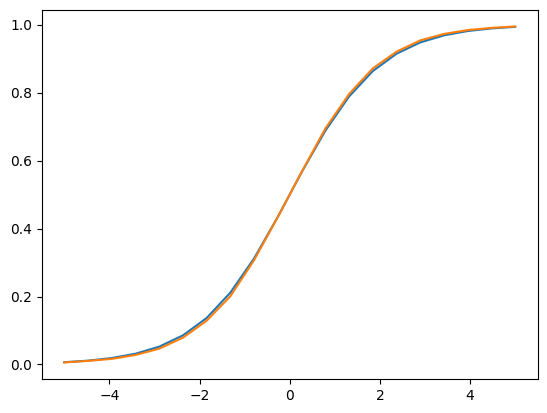

In [6]:
plt.plot(v_values, p_up, label='p_up')
plt.plot(v_values, p_up_sim_arr, label='p_up_sim')

# training data

Text(0, 0.5, 'a')

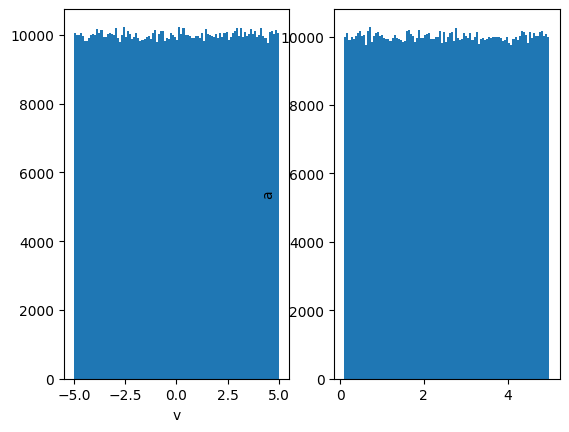

In [7]:
# pick 100k numbers uniform from -5 to 5
v_samples = np.random.uniform(-5,5, int(1e6))
a_samples = np.random.uniform(0.1, 5, int(1e6))

plt.figure()
plt.subplot(1,2,1)
plt.hist(v_samples, bins=100)
plt.xlabel('v')

plt.subplot(1,2,2)
plt.hist(a_samples, bins=100)  
plt.ylabel('a')

# P(up) = 1 - ( 1 - np.exp( -v*a ) ) / ( np.exp( v*a ) - np.exp( - v*a ) )

# neural network

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim


# define network

In [9]:
import torch.nn as nn

class ChoiceNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ChoiceNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, 1)
        # Removed the sigmoid layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # Do not apply sigmoid here
        return out  # Return raw logits


# Check inputs

In [10]:
inputs = torch.randn(100, 2)
targets = torch.sigmoid(torch.randn(100, 1))  # Simulated probabilities

print(inputs.shape, targets.shape)

v_min = -5; v_max = 5
a_min = 0.1; a_max = 5

v_samples = torch.tensor(np.random.uniform(v_min, v_max, int(100))).float()
a_samples = torch.tensor(np.random.uniform(a_min, a_max, int(100))).float()

v_a_samples = torch.stack([v_samples, a_samples], dim=1)

# P_up should be 1 - ( 1 - np.exp( -v*a ) ) / ( np.exp( v*a ) - np.exp( - v*a ) )
targets = 1 - ( 1 - torch.exp( -v_samples*a_samples ) ) / ( torch.exp( v_samples*a_samples ) - torch.exp( - v_samples*a_samples ) )

print(v_a_samples.shape, targets.shape)
rand_int = np.random.randint(0, 100)
v_a_samples[rand_int,:], targets[rand_int]
v1, a1 = v_a_samples[rand_int,:]
print(v1.item(),a1.item())
v1 = v1.item(); a1 = a1.item()
p_down_check = ( 1 - np.exp( -v1*a1 ) ) / ( np.exp( v1*a1 ) - np.exp( - v1*a1 ) )
p_up_check = 1 - p_down_check


print(f'torch theory = {targets[rand_int].item():.4f}, theory = {p_up_check:.4f}')

torch.Size([100, 2]) torch.Size([100, 1])
torch.Size([100, 2]) torch.Size([100])
-2.996107816696167 0.6625751852989197
torch theory = 0.1208, theory = 0.1208


# loss plot

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def live_plot(all_loss_arr, title, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(np.arange(1, len(all_loss_arr)+1), all_loss_arr)
    plt.xlabel('epoch')
    plt.title(title)
    plt.show()


# network init

## 3 layer model

In [17]:
class ChoiceNet_3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(ChoiceNet_3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, 1)
        # No sigmoid layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        # Do not apply sigmoid here; BCEWithLogitsLoss expects raw logits
        return out

    

all_loss = []

# nn params
input_size = 2
hidden_size1 = 100; hidden_size2 = 50
learning_rate = 3e-5
num_epochs = int(1e6)
batch_size = 128

model = ChoiceNet_3(input_size, hidden_size1, hidden_size2)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, verbose=True)

# shapes for reference
# inputs = torch.randn(100, input_size)
# targets = torch.sigmoid(torch.randn(100, 1))  # Simulated probabilities

# Training loop
for epoch in range(num_epochs):
    # inputs 
    v_samples = torch.tensor(np.random.uniform(v_min, v_max, int(batch_size))).float()
    a_samples = torch.tensor(np.random.uniform(a_min, a_max, int(batch_size))).float()
    inputs = torch.stack([v_samples, a_samples], dim=1)

    # targets - unsqueeze to make it 100 x 1 from 100
    targets = (1 - ( 1 - torch.exp( -v_samples*a_samples ) ) / ( torch.exp( v_samples*a_samples ) - torch.exp( - v_samples*a_samples ) )).unsqueeze(1)
    targets[torch.isnan(targets)] = 0.5 # if v = 0, then targets = 0/0, limit is 0.5

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Scheduler step
    # scheduler.step(loss)

    all_loss.append(loss.item())

    # if epoch % 1000 == 0: # 3m 13s with this  - 500k epochs, 2m 28 s w/o live plot
    #     live_plot(all_loss, title=f'epoch {epoch}/num_epochs')
    #     print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
    
print(f'Final loss = {loss.item():.4f}')

Final loss = 0.2074


# Testing 3 layer model

In [18]:
with torch.no_grad():
    v_samples = torch.tensor(np.random.uniform(v_min, v_max, int(batch_size))).float()
    a_samples = torch.tensor(np.random.uniform(a_min, a_max, int(batch_size))).float()
    inputs = torch.stack([v_samples, a_samples], dim=1)

    # targets - unsqueeze to make it 100 x 1 from 100
    targets = (1 - ( 1 - torch.exp( -v_samples*a_samples ) ) / ( torch.exp( v_samples*a_samples ) - torch.exp( - v_samples*a_samples ) )).unsqueeze(1)
    targets[torch.isnan(targets)] = 0.5 # if v = 0, then targets = 0/0, limit is 0.5

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    print(f'Final loss = {loss.item():.4f}')

Final loss = 0.2213


Text(0.5, 0, 'p up')

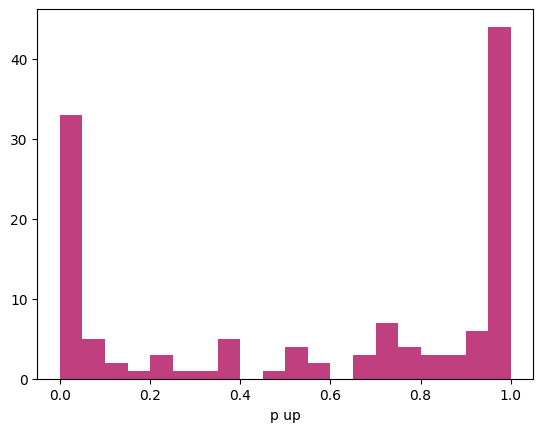

In [29]:
plt.hist(targets.numpy(), bins=20, label='target', color='b', alpha=0.5);
plt.hist(torch.sigmoid(outputs).numpy(), bins=20, label='output', color='r', alpha=0.5);
plt.xlabel('p up')

# take choice and learn RT

##  2 layer model

In [ ]:
all_loss = []

# nn params
input_size = 2
hidden_size = 50
learning_rate = 3e-5
num_epochs = int(1e6)
batch_size = 128

model = ChoiceNet(input_size, hidden_size)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, verbose=True)

# shapes for reference
# inputs = torch.randn(100, input_size)
# targets = torch.sigmoid(torch.randn(100, 1))  # Simulated probabilities

# Training loop
for epoch in range(num_epochs):
    # inputs 
    v_samples = torch.tensor(np.random.uniform(v_min, v_max, int(batch_size))).float()
    a_samples = torch.tensor(np.random.uniform(a_min, a_max, int(batch_size))).float()
    inputs = torch.stack([v_samples, a_samples], dim=1)

    # targets - unsqueeze to make it 100 x 1 from 100
    targets = (1 - ( 1 - torch.exp( -v_samples*a_samples ) ) / ( torch.exp( v_samples*a_samples ) - torch.exp( - v_samples*a_samples ) )).unsqueeze(1)
    targets[torch.isnan(targets)] = 0.5 # if v = 0, then targets = 0/0, limit is 0.5

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Scheduler step
    # scheduler.step(loss)

    all_loss.append(loss.item())

    # if epoch % 1000 == 0: # 3m 13s with this  - 500k epochs, 2m 28 s w/o live plot
    #     live_plot(all_loss, title=f'epoch {epoch}/num_epochs')
    #     print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
    
print(f'Final loss = {loss.item():.4f}')